In [1]:
import numpy as np
import pandas as pd
from random import shuffle

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

In [3]:
def read_bank_note(test=False, data_frame=False):
    colnames=['variance', 'skewness', 'curtosis', 'entropy', 'y']
    if test:
        data = pd.read_csv('../data/bank-note/test.csv', header=None, names=colnames)
    else:
        data = pd.read_csv('../data/bank-note/train.csv', header=None, names=colnames)
    data['y'] = data['y'].apply(lambda x: -1 if x<1 else 1)
    if data_frame:
        return data
    else:
        X = data.drop('y', axis=1).values
        y = data['y'].values
        return X, y

In [4]:
def add_bias(X):
    bias = np.ones(X.shape[0]).reshape(-1, 1)
    X_fit = X.copy()
    X_fit = np.concatenate([bias, X_fit], axis=1)
    return X_fit

In [5]:
def pos_neg(x):
    return 1 if x > 0 else -1

In [6]:
def get_sign(y):
    return np.array(list(map(pos_neg, y)))

In [7]:
def get_accuracy(y_pred, y):
    return (y_pred == y).sum() / len(y)

In [8]:
def get_error(y_pred, y):
    return (y_pred != y).sum() / len(y)

## Get Data

In [9]:
X_train, y_train = read_bank_note(test=False)
X_test, y_test = read_bank_note(test=True)

## Standard

In [10]:
def fit_standard(X, y, T, lr):
    
    # unpack X dimensions
    N, D = X.shape
    
    # initialize weight to zeros
    w = np.zeros(D)
    
    # get range of indicies
    idx_order = np.arange(N)
    
    # loop for number of epochs T
    for i in range(T):
        
        # shuffle data
        shuffle(idx_order)
        X = X[idx_order]
        y = y[idx_order]
        
        # loop over each row b
        for b in range(N):

            # get current X and y
            xi = X[i]
            yi = y[i]

            # multiply prediction by label
            pred = yi * w.T.dot(xi)

            # if misclassified update weight
            if pred <= 0:
                w = w + lr * yi * xi

    return w

In [11]:
def predict_standard(X, w):
    
    # get prediction
    y_pred = X.dot(w)
    
    # get sign of prediction
    y_pred = get_sign(y_pred)
    
    return y_pred

## Voted

In [12]:
def fit_voted(X, y, T, lr):
    
    # unpack X dimensions
    N, D = X.shape
    
    # initialize weight to zeros (reshape to store multiple)
    w = np.zeros(D).reshape(1, -1)
    
    # get range of indicies
    idx_order = np.arange(N)
    
    # initialize m and C
    m=0
    C = np.array([0])
    
    # loop for number of epochs T
    for i in range(T):
        
        # shuffle data
        shuffle(idx_order)
        X = X[idx_order]
        y = y[idx_order]
        
        # loop over each row
        for b in range(N):

            # get current X and y
            xi = X[i]
            yi = y[i]

            # multiply prediction by label
            pred = yi * w[m].T.dot(xi)

            # if misclassified update weight
            if pred <= 0:
                w_next = w[m].copy() + lr * yi * xi
                w = np.concatenate([w, w_next.reshape(1, -1)], axis=0)
                
                # update m and C
                m += 1
                C = np.concatenate([C, np.array([1])])
                
            # if correct add a count to current C
            else:
                C[m] += 1

    return w, C

In [13]:
def predict_voted(X, w, C):
    
    # initialize predictions to all zeros
    y_pred = np.zeros(X.shape[0])
    
    # loop over each weight vector
    for i in range(len(w)):
        
        # get prediction from current weight
        sgn = X.dot(w[i])
        
        # get sign of prediction and multiply by vote C
        sgn = C[i] * get_sign(sgn)
        
        # add predictions to y_pred
        y_pred += sgn
        
    # get sign of voted predictions
    y_pred = get_sign(y_pred)
    return y_pred

## Averaged

In [14]:
def fit_averaged(X, y, T, lr):
    
    # unpack X dimensions
    N, D = X.shape
    
    # initialize weight and average to zeros
    w = np.zeros(D)
    a = np.zeros(D)
    
    # get range of indicies
    idx_order = np.arange(N)
    
    # loop for number of epochs T
    for i in range(T):
        
        # shuffle data
        shuffle(idx_order)
        X = X[idx_order]
        y = y[idx_order]
        
        # loop over each row
        for b in range(N):

            # get current X and y
            xi = X[i]
            yi = y[i]

            # multiply prediction by label
            pred = yi * w.T.dot(xi)

            # if misclassified update weight
            if pred <= 0:
                w = w + lr * yi * xi
                
            # add weight to average
            a = a + w
            
#     a = a / (T * N)

    return a

## Perceptron

In [15]:
class Perceptron(object):
    
    def __init__(self, version='standard', lr=0.1):
        
        self.version = version
        self.lr = lr
        
    def fit(self, X, y, T=10):
        
        X_fit = add_bias(X)
        
        if self.version == 'standard':
            self.w = fit_standard(X_fit, y, T, self.lr)
        if self.version == 'voted':
            self.w, self.c = fit_voted(X_fit, y, T, self.lr)
        if self.version == 'averaged':
            self.w = fit_averaged(X_fit, y, T, self.lr)
            
        
    def predict(self, X):
        
        X_pred = add_bias(X)
        
        if self.version == 'standard':
            y_pred = predict_standard(X_pred, self.w)
        if self.version == 'voted':
            y_pred = predict_voted(X_pred, self.w, self.c)
        if self.version == 'averaged':
            y_pred = predict_standard(X_pred, self.w)
            
        return y_pred

## Results

In [16]:
# fit data with every version of perceptron once
lr = 0.01
T = 10

for ver in ['standard', 'voted', 'averaged']:
    model = Perceptron(version=ver, lr=lr)
    model.fit(X_train, y_train, T=T)
    y_pred = model.predict(X_train)
    print(ver.capitalize())
    print(f"Error:    {round(get_error(y_pred, y_train), 4)}")
    print(f"Accuracy: {round(get_accuracy(y_pred, y_train), 4)}\n")

Standard
Error:    0.3016
Accuracy: 0.6984

Voted
Error:    0.3532
Accuracy: 0.6468

Averaged
Error:    0.2672
Accuracy: 0.7328



In [17]:
# fit data with every version of perceptron multiple times
iterations=20
lr = 0.01
T = 10

results_train={'standard': [], 'voted': [], 'averaged': []}
results_test={'standard': [], 'voted': [], 'averaged': []}

for ver in ['standard', 'voted', 'averaged']:
    model = Perceptron(version=ver, lr=lr)
    
    for i in range(iterations):
        model.fit(X_train, y_train, T=T)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        results_train[ver].append(get_error(y_pred_train, y_train))
        results_test[ver].append(get_error(y_pred_test, y_test))
        
results_train = pd.DataFrame(results_train)
results_test = pd.DataFrame(results_test)

In [18]:
print('Average Training Error')
print(results_train.mean())
print('\nAverage Test Error')
print(results_test.mean())

Average Training Error
standard    0.229644
voted       0.236525
averaged    0.245585
dtype: float64

Average Test Error
standard    0.2369
voted       0.2402
averaged    0.2535
dtype: float64


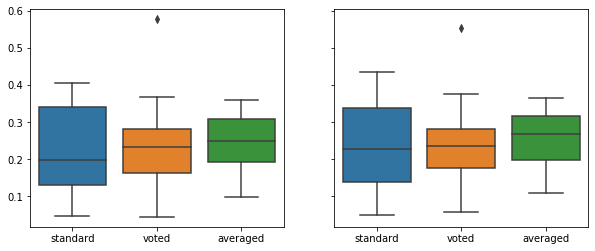

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))
sns.boxplot(data=results_train, ax=ax[0])
sns.boxplot(data=results_test, ax=ax[1])
plt.show()